In [2]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)

True

In [3]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

# from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from typing import List, Sequence

In [4]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a Twitter expert assigned to craft outstanding tweets.
     Generate the most engaging and impactful tweet possible based on the user's request.
     If the user provides feedback, refine and enhance your previous attempts accondingly for maximum engagement.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.7)

generate_chain = generation_prompt | llm

In [5]:
generate_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [6]:
tweet = ""
request = HumanMessage(content="Fifa World Cup 26")

for chunk in generate_chain.stream({"messages": [request]}):
    print(chunk.content, end="")
    tweet += chunk.content

🌍⚽️ Countdown to the #FIFAWorldCup2026! 🎉🏆 The world’s biggest soccer celebration is coming to North America! Who are you rooting for? 🇺🇸🇨🇦🇲🇽 Let’s make history together! 🌟 #WorldCup26 #SoccerLove #GoalGetters

# Reflect and Repeat

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
You are a Twitter influencer known for your enganging content and sharp insights.
Review and critique the user's tweet.
Provide constructive feedback, focusing on enhancing its depth, style and overall impact.
Offer specific suggestions to make the tweet more compelling and engaging for their audience
""",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [8]:
reflect_chain = reflection_prompt | llm

In [9]:
reflect_chain

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [10]:
reflection = ""

for chunk in reflect_chain.stream({"messages": [request, HumanMessage(content=tweet)]}):
    print(chunk.content, end="")
    reflection += chunk.content

Your tweet is off to a great start with its vibrant emojis and enthusiastic tone! However, we can enhance its depth and style to make it even more engaging and impactful. Here are some suggestions:

**1. Add a Personal Touch:** Instead of a general call to action, share who *you* are rooting for and why. This invites your audience to connect on a more personal level.

**2. Create Urgency:** Mention specific aspects of the upcoming World Cup that make it exciting (e.g., first time in North America since 1994, new cities hosting, etc.). This will create a sense of urgency and anticipation.

**3. Encourage Interaction:** Ask a more specific question to spark conversation. Instead of “Who are you rooting for?”, you could ask, “What’s your favorite World Cup memory?” or “Which team do you think will surprise us?”

**4. Use Hashtags Strategically:** While your hashtags are good, consider adding one or two more that are trending or specific to your audience, like #SoccerFans or #FootballFever

In [11]:
for chunk in generate_chain.stream(
    {"messages": [request, AIMessage(content=tweet), HumanMessage(content=reflection)]}
):
    print(chunk.content, end="")

Absolutely! Here’s a refined version of the tweet that incorporates your suggestions for deeper engagement:

🌍⚽️ The countdown to the #FIFAWorldCup2026 is on! 🎉🏆 I’m cheering for 🇺🇸 because nothing beats the thrill of home games! What’s your favorite World Cup memory? Let’s make history together and share the excitement! 🌟⚽️ #WorldCup26 #SoccerLove #FootballFever #SoccerFans

This version adds a personal touch, encourages interaction, and maintains that vibrant energy! What do you think?

# Define the Graph

In [12]:
from langgraph.graph import END, StateGraph
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages


In [16]:
class State(TypedDict):
    # Accumulate messages across nodes
    messages: Annotated[list[BaseMessage], add_messages]


def generation_node(state: State) -> dict:
    ai_msg: BaseMessage = generate_chain.invoke({"messages": state["messages"]})
    return {"messages": [ai_msg]}


def reflection_node(state: State) -> dict:
    # message to adjust
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    msgs = state["messages"]
    # first message is the original user request. we keep it the same for all nodes
    translated = [msgs[0]] + [cls_map[m.type](content=m.content) for m in msgs[1:]]
    res: BaseMessage = reflect_chain.invoke({"messages": translated})

    return {"messages": [HumanMessage(content=res.content)]}


MAX_ITERATIONS = 3


def should_continue(state: State):
    if len(state["messages"]) > MAX_ITERATIONS:
        return END
    return "continue"


builder = StateGraph(state_schema=State)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.set_entry_point("generate")
builder.add_conditional_edges(
    source="generate", path=should_continue, path_map={"continue": "reflect", END: END}
)
builder.add_edge("reflect", "generate")

graph = builder.compile()

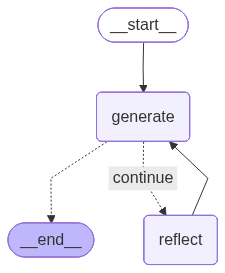

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
inputs = {
    "messages": [HumanMessage(content="Generate a tweet about Fifa World Cup 26")]
}
final_state = graph.invoke(inputs)

for msg in final_state["messages"]:
    print(msg.content)
    print("\n" + "-" * 100 + "\n")

Generate a tweet about Fifa World Cup 26

----------------------------------------------------------------------------------------------------

🌍⚽️ The countdown to FIFA World Cup 2026 begins! 🎉 With matches across the USA, Canada, and Mexico, this tournament promises to be a celebration of soccer like never before. Who are you cheering for? Let the games begin! 🏆 #FIFAWorldCup26 #SoccerUnited

----------------------------------------------------------------------------------------------------

Your tweet captures the excitement surrounding the FIFA World Cup 2026, which is fantastic! However, we can enhance its depth and engagement by adding some more specific details and inviting your audience to participate in a conversation. Here’s a revised version:

---

🌍⚽️ The countdown to FIFA World Cup 2026 is ON! 🎉 With thrilling matches across the USA, Canada, and Mexico, this tournament is set to redefine soccer fandom. 🌟 Which team are you backing, and what match-up are you most excited t

# Tracing Langsmith

In [ ]:
pip install -q langsmith


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
from langsmith import traceable
from openai import Client

openai = Client()


@traceable
def format_prompt(user_prompt):
    return [
        {"role": "system", "content": "You are a helpful assistant"},
        {
            "role": "user",
            "content": f"Generate three good names for a online store that sells {user_prompt}",
        },
    ]


@traceable(run_type="llm")
def invoke_llm(messages):
    return openai.chat.completions.create(
        messages=messages, model="gpt-4o-mini", temperature=0
    )


@traceable
def parse_output(response):
    return response.choices[0].message.content


@traceable
def run_pipeline():
    messages = format_prompt("origami paper")
    response = invoke_llm(messages)
    return parse_output(response)


run_pipeline()

'Here are three creative names for your online store that sells origami paper:\n\n1. **Folded Dreams** - This name evokes the artistry and imagination involved in origami, suggesting that each piece of paper can transform into something beautiful.\n\n2. **Origami Oasis** - This name conveys a sense of tranquility and creativity, inviting customers to explore a wide variety of origami paper options.\n\n3. **Paper Petals** - This name highlights the delicate nature of origami and suggests a focus on beautiful, high-quality paper that can be used to create intricate designs.'